# Q1
Generate your own random numbers in range [0,1] using multiplicative linear congruential generator defined by:
<!-- xn = (a xn−1) mod m -->
$$ x_n = (a x_{n-1}) \mod m $$

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange

In [78]:
class Random:
    def __init__(self, seed: float = 0.1, range: list = [0, 1]):
        self.seed = seed
        self.scale = lambda x: range[0] + x*(range[1]-range[0])

    def MLC(self, a, m):
        self.seed = (a*self.seed) % m
        return self.scale(self.seed / m)

using a = 65, m = 1021

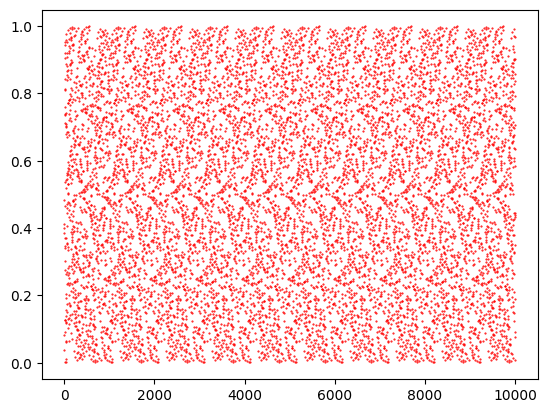

In [79]:
r1 = Random(seed=22, range=[0, 1])
N = int(1e4)
x1 = [r1.MLC(a=65, m=1021) for _ in range(N)]
plt.plot(x1, "r.", markersize=1)

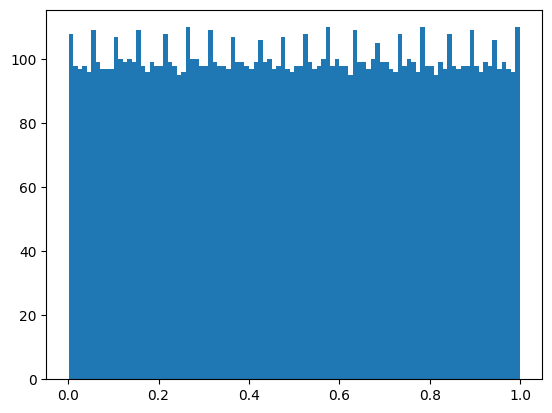

In [80]:
a = plt.hist(x1, bins=100)

using a = 572, m = 16381

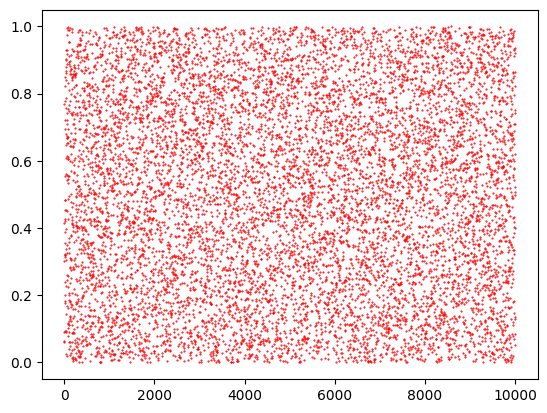

In [81]:
r2 = Random(seed=22, range=[0, 1])
N = int(1e4)
x2 = [r2.MLC(a=572, m=16381) for _ in range(N)]
plt.plot(x2, "r.", markersize=1)

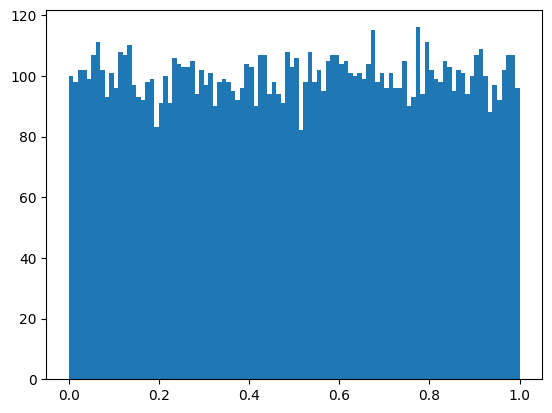

In [82]:
a = plt.hist(x2, bins=100)

Here we can clearly see that a=572,m=16381 is better choice than a=65,m=1021 from the generated graphs.

# Q2
Use Monte Carlo and pRNG of Problem 1 to approximate the integral $ \int_{-\pi/2}^{\pi/2} \cos{x} dx $. Consider $N \in [1000, 100000]$ in steps of 1000 and plot the convergence.

In [83]:
import random
def monte_carlo_integrate(f, N, ll, ul, a, m, seed=22):
    r = Random(seed=seed, range=[ll, ul])
    s = 0
    for _ in range(N):
        s += f(r.MLC(a=a, m=m))
    return s / N * (ul - ll)

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:09<00:00, 10.48it/s]


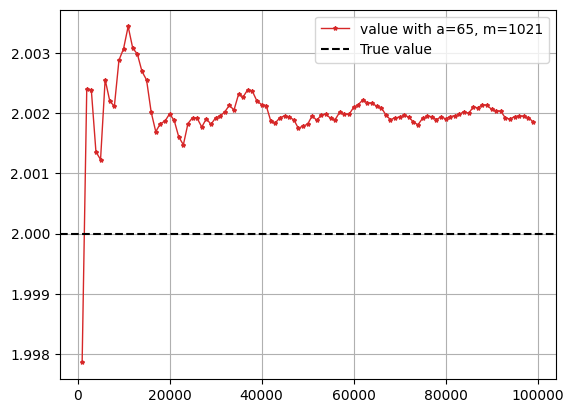

In [84]:
tests = np.arange(1e3, 1e5, 1e3, dtype=int)
values = np.zeros(len(tests))  # empty array to store the results

func = lambda x: np.cos(x)
for i, N in enumerate(tqdm(tests)):
    values[i] = monte_carlo_integrate(
        func,
        N,
        ll = -np.pi/2,
        ul = np.pi/2,
        a = 65,
        m = 1021
    )

plt.plot(tests, values, color="tab:red", marker="*", markersize=3, linewidth=1, label="value with a=65, m=1021")
plt.grid()
plt.axhline(y=2, color="k", linestyle="--", label="True value")
plt.legend()

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:09<00:00, 10.79it/s]


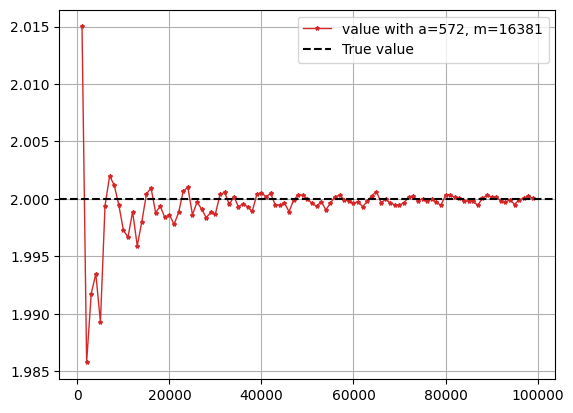

In [85]:
tests = np.arange(1e3, 1e5, 1e3, dtype=int)
values = np.zeros(len(tests))  # empty array to store the results

func = lambda x: np.cos(x)
for i, N in enumerate(tqdm(tests)):
    values[i] = monte_carlo_integrate(
        f  = func,
        N  = N,
        ll = -np.pi/2,
        ul = np.pi/2,
        a  = 572,
        m  = 16381
    )

plt.plot(tests, values, color="tab:red", marker="*", markersize=3, linewidth=1, label="value with a=572, m=16381")
plt.grid()
plt.axhline(y=2, color="k", linestyle="--", label="True value")
plt.legend()

Here we can see that for a=65,m=1021 the convergence is not good as compared to a=572,m=16381.

In the first case, the result converges to 2.002 rather than 2.0. In the second case, the result converges to 2.0. In the first case, the result is wrong not because there is something wrong in the code, but because the random numbers generated are not good enough.

As a result we would use a=572, m=16381 for the rest of the problems.

# Q3

Generate pseudo random numbers distributed as $\exp(−2x)$ for $0 \leq x \leq 3$ using inverse transform method and accept / reject method using sampling distribution $q(x) = 1 − x$, $0 \leq x \leq 1$. Histogram the sampled RNG in both case (generate at least 2000 RNs for the purpose).

## Inverse Transform Method

In [86]:
class RandomDist(Random):
    def __init__(self, seed: float = 0.1, f_inv: callable = lambda x: x, range=[0, 3]):
        super().__init__(seed)
        self.transform = f_inv
        self.range = range
    def MLC(self, a=572, m=16381):
        while True:
            u = self.transform(Random.MLC(self, a=a, m=m))
            if u >= self.range[0] and u <= self.range[1]:
                return u

In [87]:
from library.integration import midpoint_rule

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 394832.34it/s]


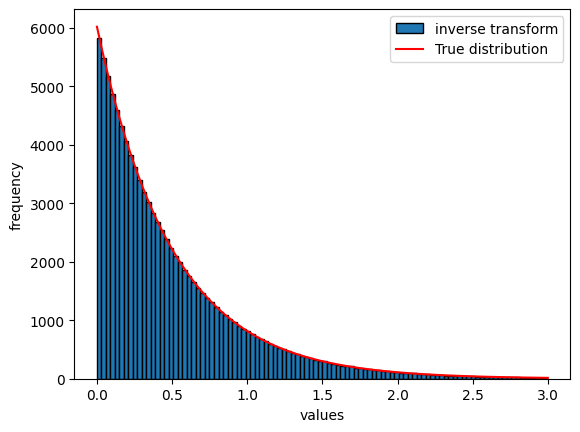

In [88]:
N = int(1e5)
bins = 100
till = 3
r = RandomDist(seed=22, f_inv=lambda u: -np.log(u)/2, range=[0, till])
distribution = [r.MLC(a=572, m=16381) for _ in trange(N)]

# plot the histogram
plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="inverse transform")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the true distribution
x = np.linspace(0, till, 100)
f = lambda x: np.exp(-2*x)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
plt.plot(x, f_x, "r", label="True distribution")

plt.legend()

## Accept / Reject Method

In [163]:
def generate_accept_reject_rng(f, g, r, ru, limits=[0, 3], a=572, m=16381):
    """Generate a random number using the accept-reject method.

    Args:
        f (callable): The distribution function.
        g (callable): The **scaled** model distribution function.
        r (Random): The random number generator. Which returns a random number from the model distribution (g).
        ru (Random): The random number generator. Which returns a random number from the uniform distribution.
        limits (list, optional): The limits of the distribution. Defaults to [0, 3].
        a, m (int, optional): Parameters for the random number generator. Defaults to 572, 16381.

    Returns:
        float: A random number from the provided distribution function f.
    """
    rejections = 0
    while True:
        u = r.MLC(a=a, m=m)
        p = ru.MLC(a=a, m=m)
        if p < (f(u) / g(u)):
            return u, rejections
        rejections += 1

In [164]:
class RandomDist(Random):
    def __init__(self, seed: float = 0.1, f_inv: callable = lambda x: x, range=[0, 3]):
        super().__init__(seed)
        self.transform = f_inv
        self.range = range
    def MLC(self, a=572, m=16381):
        while True:
            u = self.transform(Random.MLC(self, a=a, m=m))
            if u >= self.range[0] and u <= self.range[1]:
                return u

1990.0000000000014


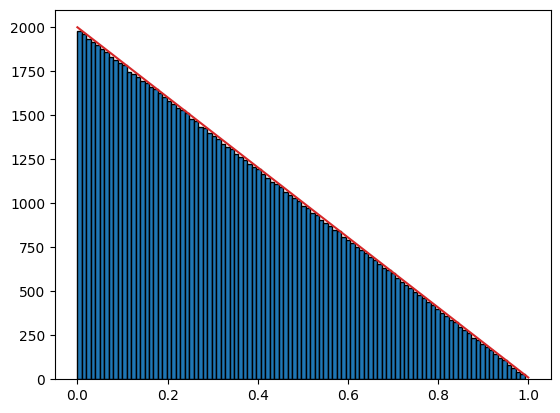

In [165]:
c = 2
d = 1
N = int(1e5)
g = lambda x: 1-x  # model distribution
g_inv = lambda y: 1-(y)**0.5
f = lambda x: np.exp(-2*x)  # required distribution

r = RandomDist(seed=0.1, f_inv=g_inv, range=[0, 1])

# plt.plot(ys, "r.", markersize=1)
h = plt.hist([r.MLC() for _ in range(N)], bins=bins, color="tab:blue", edgecolor="k", label="inverse transform")

# xs = np.linspace(0, 1, 100)
# plt.plot(xs, g(xs), "tab:red", label="model distribution")



# plot the model and target distributions
x = np.linspace(0, till, 100)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(g, 0, till/bins) / midpoint_rule(g, 0, till)
print(norm*d)
g_x = g(x-till/(bins*2)) * norm
plt.plot(x, g_x, "tab:red", label="model distribution")

### Here we would see three cases, where we will change the model function and see the 

100%|██████████| 100000/100000 [00:00<00:00, 179286.21it/s]


Acceptance rate: 83.83%


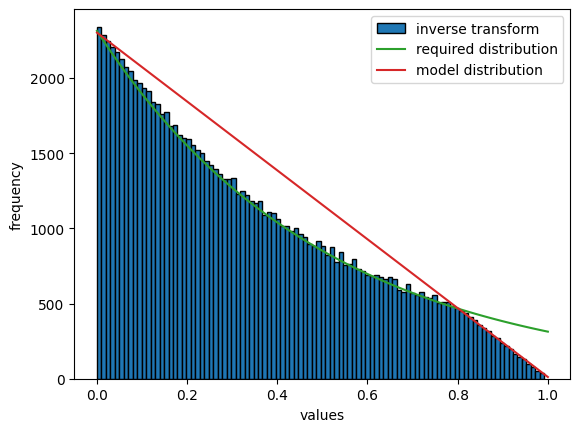

In [166]:
N = int(1e5)
bins = 100
till = 1

g = lambda x: 1-x  # model distribution
g_inv = lambda y: 1-(y)**0.5  # make sure this is the inverse of g
# check_inverse(g, g_inv)
f = lambda x: np.exp(-2*x)  # required distribution

r = RandomDist(seed=22, f_inv=g_inv, range=[0, till])  # model distribution RN generator
ru = Random(seed=21.9)  # uniform RN generator
distribution = []
rejections = []

for _ in trange(N):
    u, rejection = generate_accept_reject_rng(
        f = f,
        g = g,
        r = r,
        ru = ru,
        limits=[0, till],
    )
    distribution.append(u)
    rejections.append(rejection)

a = plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="inverse transform")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the model and target distributions
x = np.linspace(0, till, 100)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
g_x = g(x-till/(bins*2)) * norm
plt.plot(x, f_x, "tab:green", label="required distribution")
plt.plot(x, g_x, "tab:red", label="model distribution")

plt.legend()
print(f"Acceptance rate: {100/(np.mean(rejections)+1):.2f}%")

Generating random numbers:   0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 43.20%


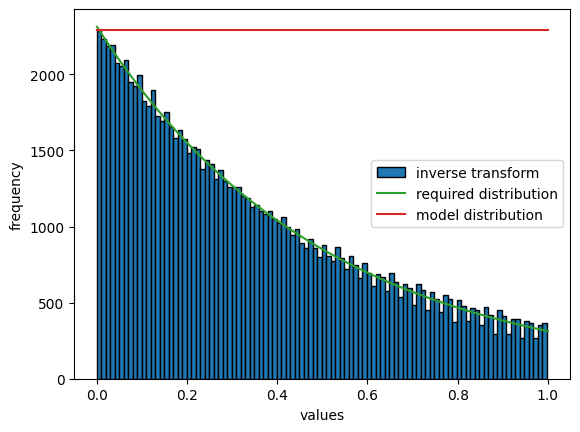

In [167]:
N = int(1e5)
bins = 100
till=1

g = lambda x: x**0  # model distribution
g_inv = lambda u: u
f = lambda x: np.exp(-2*x)  # required distribution

r = Random(seed=22, range=[0, till])  # model distribution RN generator
ru = Random(seed=21.9)  # uniform RN generator
distribution = []
rejections = []

for _ in trange(N, desc="Generating random numbers", leave=False):
    u, rejection = generate_accept_reject_rng(
        f = f,
        g = g,
        r = r,
        ru = ru,
        limits=[0, till],
    )
    distribution.append(u)
    rejections.append(rejection)

plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="inverse transform")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the model and target distributions
x = np.linspace(0, till, 100)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
g_x = g(x-till/(bins*2)) * norm
plt.plot(x, f_x, "tab:green", label="required distribution")
plt.plot(x, g_x, "tab:red", label="model distribution")

plt.legend()
print(f"Acceptance rate: {100/(np.mean(rejections)+1):.2f}%")

100%|██████████| 100000/100000 [00:00<00:00, 107213.45it/s]


Acceptance rate: 83.55%


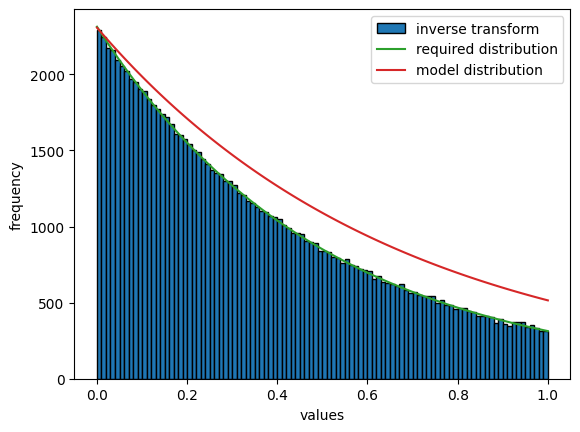

In [169]:
N = int(1e5)
bins = 100
till=1
c = 1.5
g = lambda x: np.exp(-c*x)  # model distribution
g_inv = lambda u: -np.log(u) / c  # make sure this is the inverse of g
f = lambda x: np.exp(-2*x)  # required distribution

r = RandomDist(seed=22, f_inv=g_inv, range=[0, till])  # model distribution RN generator
ru = Random(seed=21.9)  # uniform RN generator
distribution = []
rejections = []

for _ in trange(N):
    u, rejection = generate_accept_reject_rng(
        f = f,
        g = g,
        r = r,
        ru = ru,
        limits=[0, till],
    )
    distribution.append(u)
    rejections.append(rejection)

plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="inverse transform")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the model and target distributions
x = np.linspace(0, till, 100)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
g_x = g(x-till/(bins*2)) * norm
plt.plot(x, f_x, "tab:green", label="required distribution")
plt.plot(x, g_x, "tab:red", label="model distribution")

plt.legend()
print(f"Acceptance rate: {100/(np.mean(rejections)+1):.2f}%")

# Q4

Use Monte Carlo to evaluate the integral (taking $N = 10,000$)

$$\int_0^2\frac{e^{-2x}}{1+x^2}dx$$

with the following importance sampling functions and comment on the variance reduction that may be achieved.

$p_1(x)=0.5\;;\;0 \le x \le 2$

$p_2(x)=e^{-x}\;;\;0 \le x$

$p_3(x)=\frac{e^{-\frac{x}{2}}}{2\left(1+e^{-\frac{1}{2}}\right)}\;;\;0 \le x \le 2$

In [203]:
def monte_carlo_integration(func, sampling_func, r, a, b, num_samples=10_000):
    x = np.random.uniform(a, b, int(num_samples))
    h = (b-a) / num_samples
    integral_sum = np.sum(h*func(x))
    integral = integral_sum
    return integral

In [204]:
f = lambda x: np.exp(-2*x) / (1 + x**2)

estimated_integral = monte_carlo_integration(f, 0, 1, 1e8)
print("Estimated integral:", estimated_integral)

Estimated integral: 0.3760838846723566


In [205]:
def monte_carlo_integration_importance_sampling(func, sampling_func, a, b, num_samples=10000):
    # Generate samples according to the sampling distribution
    x_samples = sampling_func(num_samples)
    
    # Evaluate the integrand at the samples
    integrand_values = func(x_samples)
    
    # Calculate the importance sampling weights
    weights = integrand_values / sampling_func(x_samples)
    
    # Calculate the integral estimate
    integral_estimate = np.mean(weights)
    
    # Scale the estimate by the range of integration
    integral_estimate *= (b - a)
    
    return integral_estimate

# Function to integrate: f(x) = e^(-2x) / (1 + x^2)
def func(x):
    return np.exp(-2*x) / (1 + x**2)

# Importance sampling function: p2(x) = e^(-x)
def sampling_func(num_samples):
    return -np.log(np.random.rand(num_samples))

# Define the integration bounds
a = 0
b = np.inf  # We consider an upper bound of infinity for p2(x)

# Perform Monte Carlo integration with importance sampling using p2(x)
estimated_integral = monte_carlo_integration_importance_sampling(func, sampling_func, a, b)
print("Estimated integral with importance sampling (p2(x)):", estimated_integral)

TypeError: only integer scalar arrays can be converted to a scalar index